# Relatório - Predição de interesse em produtos

Este notebook tem dois objetivos principais: criar uma clusterização dos produtos vendidos pelo Magazine Luiza a partir do histórico de vendas e prever a venda de cada um dos seus produtos. Outros objetivos desse estudo incluem a análise da qualidade dos clusters e compreensão das principais características dos mesmos.

Neste projeto optou-se por utilizar o algoritmo KMeans para clusterização e o algoritmo ARIMA para a predição. 

Este documento é dividido da seguinte forma:

1. Análise exploratória
2. Implementação e análise do cluster
3. Implementação e análise do modelo preditivo
4. Conclusões
5. Referências

As linhas de código abaixo apenas carregam o dataset em memória e definem algumas funções úteis para esse projeto. 

In [181]:
import pandas as pd
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.vq import kmeans,vq
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


sns.set(color_codes=True)

df = pd.read_csv("data/desafio.csv")

In [182]:
# HELPER FUNCTION DEFINITIONS
def plot_elbow_curve(X, K):
    # scipy.cluster.vq.kmeans
    KM = [kmeans(X,k) for k in K]
    centroids = [cent for (cent,var) in KM]   # cluster centroids
    avgWithinSS = [var for (cent,var) in KM] # mean within-cluster sum of squares

    # alternative: scipy.cluster.vq.vq
    #Z = [vq(X,cent) for cent in centroids]
    #avgWithinSS = [sum(dist)/X.shape[0] for (cIdx,dist) in Z]

    # alternative: scipy.spatial.distance.cdist
#     D_k = [cdist(X, cent, 'euclidean') for cent in centroids]
#     cIdx = [np.argmin(D,axis=1) for D in D_k]
#     dist = [np.min(D,axis=1) for D in D_k]
#     avgWithinSS = [sum(d)/X.shape[0] for d in dist]

    ##### plot ###
    kIdx = 3
    # elbow curve
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
        markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()

## Análise Exploratória 

Nesta seção exploraremos as características básicas do dataset, não apenas suas dimensões mas também as características de suas variáveis. 

O dataset possui `179149` linhas e `14` variáveis (um exemplo do mesmo é mostrado abaixo). Dessas variáveis, 8 são categóricas e as demais são contínuas. Percebe-se também que todas as variáveis tem preenchimento (densidade) completo dentro do dataset. Porém, a variável `process_date` contém células com o valor `0000-00-00`, que é um formato inválido de data. Esse valor precisará ser tratado para aplicação dos algoritmos que a utilizarem como feature. 

In [183]:
print("Dimensões do dataset: {} rows e {} columns".format(df.shape[0], df.shape[1]))
num_cat_features = len( df.select_dtypes( include=['object'] ).columns )
print("Número de variáveis categóricas: {}".format( num_cat_features ) )
print("Número de variáveis contínuas: {}".format( len(df.columns) - num_cat_features ) )

def calculate_density(df):
  sparsity_dict = {}
  for col in df.columns:
    sparsity_dict[col] = df[col].count()/df.shape[0]
  return(sparsity_dict)

density_dict = calculate_density(df)
sorted_density_list = sorted(density_dict.items(), key=lambda x: x[1])

print("\n")
for l in sorted_density_list:
  print("{:25} => Density of {:4.2f}%".format(l[0], l[1]*100))

Dimensões do dataset: 179149 rows e 14 columns
Número de variáveis categóricas: 8
Número de variáveis contínuas: 6


category                  => Density of 100.00%
code                      => Density of 100.00%
order_id                  => Density of 100.00%
tax_substitution          => Density of 100.00%
price                     => Density of 100.00%
capture_date              => Density of 100.00%
process_status            => Density of 100.00%
order_status              => Density of 100.00%
icms                      => Density of 100.00%
pis_cofins                => Density of 100.00%
process_date              => Density of 100.00%
liquid_cost               => Density of 100.00%
source_channel            => Density of 100.00%
quantity                  => Density of 100.00%


In [137]:
df.head()

,order_id,code,quantity,price,pis_cofins,icms,tax_substitution,category,liquid_cost,order_status,capture_date,process_date,process_status,source_channel
0,bcb59c839e78b2601374cbad9239ca7b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
1,4e91ee6b95895771dc9ee524e910a902,e6762ba2ffbca07ab6cee7551caeaad5,1,1036.29,95.8568,176.1693,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,em rota de entrega,2016-06-11,2016-06-11,processado,b76eb9b8fc0f17098812da9117d3e500
2,88eb0ac86af1a521c0831298d22dea8b,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,0.0000,191.8416,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-12,2016-06-12,processado,b76eb9b8fc0f17098812da9117d3e500
3,dee418152a36314b4aee6ce9cf94fcbf,e6762ba2ffbca07ab6cee7551caeaad5,1,978.90,90.5483,176.2020,0.0000,4ece547755cba9e7fc14125bc895f31b,542.7065,cancelado,2016-06-13,0000-00-00,captado,b76eb9b8fc0f17098812da9117d3e500
4,1c175bc61b9b659bbf011b2e5e3dcec6,e6762ba2ffbca07ab6cee7551caeaad5,1,976.05,90.2846,0.0000,192.3325,4ece547755cba9e7fc14125bc895f31b,542.7065,entrega total,2016-06-13,2016-06-13,processado,b76eb9b8fc0f17098812da9117d3e500


Um dos objetivos desse estudo é prever a quantidade de vendas para cada um dos produtos. Dado isso, é importante ver como as vendas se comportam ao longo dos meses de maneiral total.

A partir do gráfico abaixo é possível ver que existem dois picos de vendas de produtos, um deles no dia `25 de novembro de 2016` e outro no dia `06 de janeiro de 2017`. Provavelmente o primeiro pico se deve ao evento da Black Friday e o segundo pico se deve ao evento de "Liquidação Fantástica do Magazine Luiza" [5]. Nos demais dias a curva de vendas permanece sem grandes oscilações.

Outro fator interessante é que, apesar de as duas data acima serem destaque em quantidades de produtos vendidos elas não representam os dias mais deram receita a empresa (`revenue = quantity * price`). O dia mais rentável foi `29 de setembro de 2016`. As duas datas acima ainda sim permanecem entre os top 5 dias mais rentáveis.  

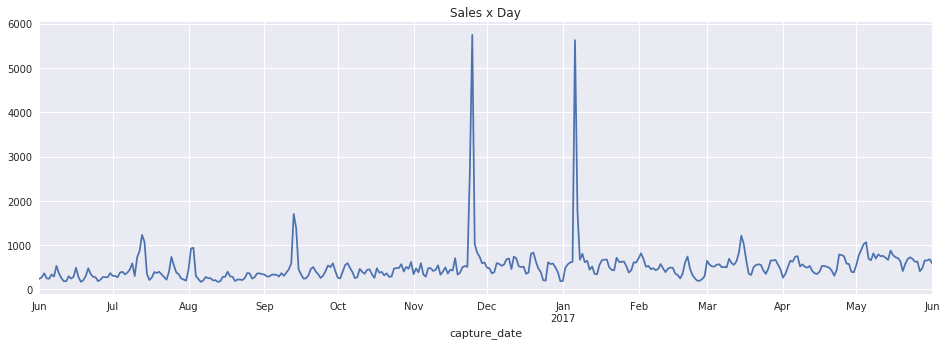

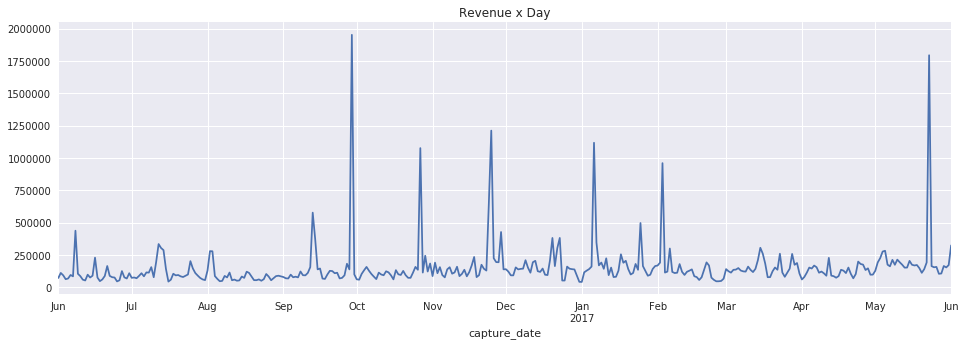

In [184]:
df['process_date'] = df['process_date'].apply(lambda x: np.nan if x == '0000-00-00' else x)
df['capture_date'] = pd.to_datetime(df['capture_date'], format="%Y/%m/%d")
df['process_date'] = pd.to_datetime(df['process_date'], format="%Y/%m/%d")

ts_quantity = df.groupby(pd.Grouper(key='capture_date', freq='D'))['quantity'].aggregate(np.sum)

df['revenue'] = df['quantity'] * df['price']

ts_revenue = df.groupby(pd.Grouper(key='capture_date', freq='D'))['revenue'].aggregate(np.sum)

plt.figure(figsize=(16,5))
plt.title("Sales x Day")
ts_quantity.plot()
plt.show()

plt.figure(figsize=(16,5))
plt.title("Revenue x Day")
ts_revenue.plot()
plt.show()

## Implementação e análise do cluster

Nesta seção construiremos o cluster. O algoritmo escolhido para cumprir essa atividade é o KMeans. Para isso, é preciso analisar como as características deste algoritmo  impactam na resolução deste problema. 

### Características do KMeans

De maneira geral, algoritmos de cluster não conseguem lidar tão bem com variáveis categóricas, pois é difícil achar uma função de distância que consiga representá-las. 

Por exemplo, dado a variável *COR* pertencente ao dataset D e que pode ter os valores *[vermelho, verde, azul, amarelo]*, é impossível dizer o quão próximo a cor `vermelho` está da cor `azul`. O KMeans se baseia na distância euclidiana entre as variáveis para montar seus clusters e esta medida, por definição, funciona apenas com variáveis contínuas. Isso nos permite dizer que deveremos tratar as variáveis categóricas presentes no dataset afim de clusterizar os produtos da melhor maneira possível. 

Após pesquisas realizadas, identificou-se duas formas principais de lidar com essa situação:

1. **1-of-K Coding** [3]: consiste em transformar todas as variáveis categóricas em _dummy vars_ e aplicar o KMeans considerando essas novas variáveis como contínuas. Esse método, apesar de ter resultados satisfatórios, aumenta drasticamente o número de variáveis presentes no dataset o que pode prejudicar a performance do algoritmo e também gerar overfitting (quando o cluster falha ao generalizar os agrupamentos de dados). 

2. **K-prototypes** [1][2][4]: esse algoritmo é baseado no KMeans e no KModes. É adaptado para lidar com um mix de variáveis categóricas e contínuas, usando medidas de distância adequadas para cada um desses tipos. Os trade-offs desse método se encontram na sua implementação em python [6], que possui baixa performance quando o dataset tem mais de dez mil linhas, e na falta de clareza se os métodos de validação do KMeans funcionam para ele também (nos artigos analisados essa informação não está totalmente clara). 

### Ajustes no dataset

O dataset utilizado neste projeto versa sobre o histórico de vendas e não apenas sobre as características dos produtos. Para montar a clusterização, é preciso que o dataset tenha unicidade por produto em cada uma das suas linhas e que as colunas versem sobre características dos mesmos. 

O código abaixo demonstra como o dataset de produtos foi montado. As premissas utilizadas nessa atividade foram:

1. Manter todas as variáveis numéricas já existentes no novo dataset
2. Remover as variáveis com hash, pois sua interpretação dentro do cluster não é viável, dado que não é possível identificar o significado da mesma
3. Contabilizar quantas vezes cada um dos possíveis valores das features categóricas aconteceram dentro do dataset

A partir dessas premissas é possível utilizar o KMeans sem problemas, tendo em vista que todas as variáveis serão contínuas. 

In [139]:
df_order_status = pd.get_dummies(df['order_status'], prefix="order_status")
df_process_status = pd.get_dummies(df['process_status'], prefix="process_status")

df2 = pd.concat([df, df_order_status], axis=1)
df2 = pd.concat([df2, df_process_status], axis=1)


df_grouped = df2.groupby('code').agg({'quantity': np.mean, 'price': np.mean, 
                                     'pis_cofins': np.mean, 'tax_substitution': np.mean,
                                    'liquid_cost': np.mean, 'revenue': np.mean}).reset_index()

df_grouped2 = df2.groupby('code').agg(np.sum).reset_index()
df_grouped2 = df_grouped2[df_grouped2.columns.difference(['quantity', 'price', 'pis_cofins', 'icms',
                                                         'tax_substitution', 'liquid_cost', 'revenue'])]
# df_grouped2.head()
product_dataset = df_grouped.merge(df_grouped2, how='inner', on='code') 

product_dataset.head()

# EXPORT DATASET TO CSV
# product_dataset.to_csv("data/product_dataset.csv", index=False)

,code,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,...,order_status_entrega total,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado
0,0671c2b9132a3f5215a4212ce0691694,225.445203,13.551533,213.213890,19.673568,117.0820,1.020166,182.0,1751.0,28.0,...,4151.0,6.0,0.0,32.0,28.0,93.0,2.0,0.0,1970.0,4526.0
1,09f544ec2a74c89abeec7b0590fc2d11,220.022618,11.664623,145.200961,13.410406,73.8002,1.085890,18.0,89.0,0.0,...,809.0,0.0,0.0,5.0,9.0,13.0,0.0,0.0,107.0,871.0
2,0ad316f6b5cb5e81ebff73ae2490ccfe,219.997219,11.489706,210.690798,19.373709,106.4842,1.020450,8.0,40.0,0.0,...,411.0,1.0,0.0,7.0,4.0,7.0,0.0,0.0,49.0,440.0
3,0bbe09e34a11e8e31cf49d6f8df2992d,187.256657,4.116640,167.754106,15.491333,88.9639,1.023460,8.0,40.0,1.0,...,266.0,1.0,0.0,3.0,3.0,9.0,0.0,0.0,51.0,290.0
4,0dca7ec6ba9b6e8f17f04f713a6be727,149.058133,2.273317,68.569957,6.341866,27.2847,1.419528,22.0,115.0,4.0,...,691.0,1.0,0.0,13.0,6.0,15.0,0.0,1.0,145.0,787.0


### Implementação do KMeans

Um dos grandes desafios de implentar um algoritmo de clusterização é determinar qual o número ideal de clusters a ser montados. Após pesquisas realizadas, identificou-se duas formas principais de lidar com essa situação:

1. **Silhouette Análise** [7]: pode ser compreendida como o estudo da distância de separação entre os clusters resultantes do KMeans. O gráfico de silhueta exibe uma medida de quão próximo cada ponto em um cluster é para pontos nos clusters vizinhos e, portanto, fornece uma maneira de avaliar visualmente os parâmetros como número de clusters. Uma medida numérica utilizada é a _average silhouette_, que é a média dos valores das silhuetas dos clusters. Quanto maior o valor da _average silhouette_ melhor o cluster. 

2. **Elbow method** [8][9]: este método analisa a porcentagem de variância explicada como uma função do número de clusters: é preciso escolher uma série de clusters para que a adição de outro cluster não ofereça muito melhor modelagem dos dados. Mais precisamente, se uma parcela a porcentagem de variância explicada pelos clusters em relação ao número de clusters, os primeiros clusters adicionarão muita informação (explicam muita variância), mas em algum momento o ganho marginal cairá, dando um ângulo na gráfico.

Neste estudo utilizaremos o segundo método para identificação do melhor valor de `k` para o KMeans. A partir da implementação abaixo, é possível ver que os melhores valores para K são `4` e `5`. Vamos escolher arbitrariamente o valor `4` e implementar o algoritmo. Após isso, vamos associar as labels produzidas ao dataset de produtos montado anteriormente. 

É importante frisar que todas as varáiveis foram normalizadas utilizando o `MinMaxScaler` do scikit-learn. Isso permite que todas as features fiquem em um mesmo patamar de comparação. 

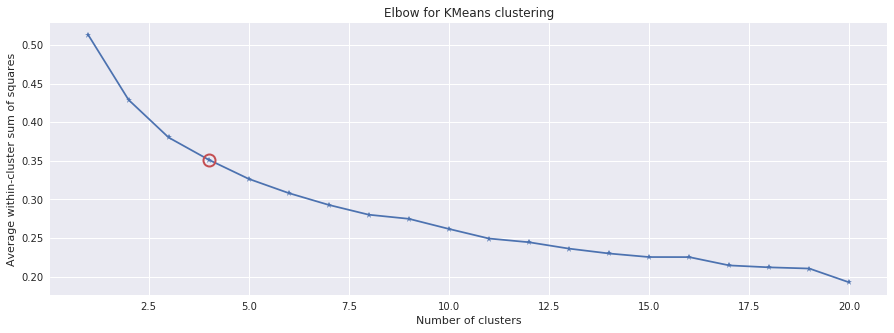

In [140]:
# REMOVE PRODUCT ID COLUMN. IT IS NOT NECESSARY TO BUILD THE CLUSTER
df3 = product_dataset[product_dataset.columns.difference(['code'])]

min_max_scaler = MinMaxScaler()
# PERFORM FEATURE SCALING
df3 = min_max_scaler.fit_transform(df3)
plot_elbow_curve(df3, range(1,21))

In [155]:
kmeans = KMeans(init='k-means++', n_clusters=4, random_state=30).fit(df3)
labels = kmeans.labels_
product_dataset['clusters'] = labels
product_dataset[product_dataset.clusters == 2].head()

,code,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,...,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado,clusters
1,09f544ec2a74c89abeec7b0590fc2d11,220.022618,11.664623,145.200961,13.410406,73.8002,1.085890,18.0,89.0,0.0,...,0.0,0.0,5.0,9.0,13.0,0.0,0.0,107.0,871.0,2
2,0ad316f6b5cb5e81ebff73ae2490ccfe,219.997219,11.489706,210.690798,19.373709,106.4842,1.020450,8.0,40.0,0.0,...,1.0,0.0,7.0,4.0,7.0,0.0,0.0,49.0,440.0,2
3,0bbe09e34a11e8e31cf49d6f8df2992d,187.256657,4.116640,167.754106,15.491333,88.9639,1.023460,8.0,40.0,1.0,...,1.0,0.0,3.0,3.0,9.0,0.0,0.0,51.0,290.0,2
4,0dca7ec6ba9b6e8f17f04f713a6be727,149.058133,2.273317,68.569957,6.341866,27.2847,1.419528,22.0,115.0,4.0,...,1.0,0.0,13.0,6.0,15.0,0.0,1.0,145.0,787.0,2
5,0f38be2df6854b4374f06cae1bc38482,232.526261,13.661960,214.635592,19.817550,117.0820,1.026540,62.0,526.0,9.0,...,1.0,0.0,32.0,7.0,22.0,0.0,1.0,600.0,1510.0,2


### Análise dos clusters resultantes

Para analisar as características que definem cada um dos clusters utilizaremos a função `describe` do scikit learn. Basicamente analisaremos as características estatísticas das variáveis. 

* **Cluster 1 (cluster_index = 0)**: é o cluster com maior receita média. Contém poucos produtos e que são comprados em sua maioria de forma unitária, ou seja, é o cluster com os produtos mais caros. 
* **Cluster 2 (cluster_index = 1)**: é o cluster identificado por cancelamentos. Possui médias elevadas de cancelamento que advém de três motivos principais: boleto não pago, dados divergentes e solicitações feitas pelo cliente para cancelamento de compra. 
* **Cluster 3 (cluster_index = 2)**: é o cluster dos produtos baratos. São produtos que tem poucos cancelamentos e muitos processamentos finalizados. 
* **Cluster 4 (cluster_index = 3)**: cluster mais balanceado em termos de caracteírsticas. Não tem nenhuma que se sobressaia em relção aos demais clusters, mas é importante ressaltar que há um número considerável de cancelamentos por boletos não pagos para esse tipo de produto. 

In [127]:
product_dataset[product_dataset.clusters == 0].describe(percentiles=[])

,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,order_status_cancelado fraude confirmada,...,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado,clusters
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.0,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.0
mean,1153.709375,54.439964,904.337302,76.392197,531.526464,1.028387,22.909091,53.636364,7.181818,1.181818,...,2.636364,0.0,2.545455,3.454545,4.000000,0.363636,0.181818,88.090909,341.272727,0.0
std,411.061919,42.177955,300.073625,37.588665,167.658993,0.040827,24.764711,56.593768,12.040085,3.600505,...,6.531045,0.0,3.908034,3.445682,4.358899,0.674200,0.404520,93.088619,347.645535,0.0
min,802.791669,0.000000,506.407299,0.000000,241.671500,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0
50%,947.955614,56.324642,870.067551,77.003243,542.706500,1.005512,18.000000,32.000000,1.000000,0.000000,...,0.000000,0.0,1.000000,2.000000,2.000000,0.000000,0.000000,57.000000,340.000000,0.0
max,2018.831606,138.374464,1582.376667,146.369861,896.681400,1.099270,76.000000,176.000000,40.000000,12.000000,...,22.000000,0.0,12.000000,11.000000,14.000000,2.000000,1.000000,255.000000,1015.000000,0.0


In [128]:
product_dataset[product_dataset.clusters == 1].describe(percentiles=[])

,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,order_status_cancelado fraude confirmada,...,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado,clusters
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000,3.0
mean,345.227587,20.398495,247.749997,16.682238,146.100133,1.061505,483.333333,1752.000000,66.666667,7.000000,...,18.000000,1.333333,77.666667,81.333333,170.666667,2.0,4.666667,2337.000000,13944.000000,1.0
std,49.659422,10.526943,82.998012,15.902662,58.744129,0.031440,105.077749,443.744296,21.548395,1.732051,...,3.464102,2.309401,51.013070,39.119475,51.325757,2.0,1.154701,341.632844,5538.598288,0.0
min,287.940286,13.954603,199.496193,0.000000,105.355700,1.037194,388.000000,1317.000000,46.000000,6.000000,...,14.000000,0.000000,26.000000,37.000000,123.000000,0.0,4.000000,2001.000000,7990.000000,1.0
50%,371.707449,14.694428,200.166734,18.377166,119.506500,1.050309,466.000000,1735.000000,65.000000,6.000000,...,20.000000,0.000000,79.000000,96.000000,164.000000,2.0,4.000000,2326.000000,14899.000000,1.0
max,376.035028,32.546455,343.587064,31.669548,213.438200,1.097010,596.000000,2204.000000,89.000000,9.000000,...,20.000000,4.000000,128.000000,111.000000,225.000000,4.0,6.000000,2684.000000,18943.000000,1.0


In [129]:
product_dataset[product_dataset.clusters == 2].describe(percentiles=[])

,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,order_status_cancelado fraude confirmada,...,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado,clusters
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,...,105.000000,105.0,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.0
mean,220.781153,11.917112,180.310997,16.638289,92.321761,1.060515,16.914286,54.285714,1.685714,0.238095,...,0.380952,0.0,3.695238,3.752381,9.133333,0.076190,0.095238,73.790476,548.200000,2.0
std,143.196487,9.592647,107.343996,9.911841,61.010171,0.082532,16.686080,65.294998,2.127269,0.546383,...,0.578143,0.0,4.863767,3.738523,7.809101,0.358824,0.325925,81.175107,463.143739,0.0
min,7.677929,0.000000,7.677929,0.710229,4.114100,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.0
50%,180.088038,9.695407,153.447222,14.150808,78.862100,1.029148,12.000000,38.000000,1.000000,0.000000,...,0.000000,0.0,2.000000,2.000000,7.000000,0.000000,0.000000,49.000000,410.000000,2.0
max,819.984556,43.523486,505.618969,46.478825,289.356300,1.419528,102.000000,526.000000,13.000000,3.000000,...,2.000000,0.0,32.000000,23.000000,37.000000,3.000000,2.000000,600.000000,2566.000000,2.0


In [131]:
product_dataset[product_dataset.clusters == 3].describe(percentiles=[])

,revenue,tax_substitution,price,pis_cofins,liquid_cost,quantity,order_status_cancelado,order_status_cancelado boleto não pago,order_status_cancelado dados divergentes,order_status_cancelado fraude confirmada,...,order_status_fraude confirmada,order_status_pendente processamento,order_status_processado,order_status_solicitação de cancelamento,order_status_solicitação de troca,order_status_suspeita de fraude,order_status_suspenso barragem,process_status_captado,process_status_processado,clusters
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.00000,12.000000,12.000000,...,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.0
mean,318.858262,14.605908,222.413488,20.528214,135.812267,1.042512,149.666667,573.25000,18.166667,1.333333,...,3.333333,0.083333,19.916667,28.833333,73.750000,1.083333,0.500000,748.166667,4274.666667,3.0
std,266.250027,7.048851,96.180490,8.890202,67.741172,0.026064,61.959420,436.91046,16.375333,1.230915,...,2.015095,0.288675,10.748855,11.223622,27.200017,0.792961,0.522233,484.537236,1533.470178,0.0
min,83.059558,5.796524,73.954865,6.823654,36.530200,1.020166,63.000000,144.00000,0.000000,0.000000,...,0.000000,0.000000,7.000000,6.000000,25.000000,0.000000,0.000000,219.000000,1875.000000,3.0
50%,240.505700,13.514785,205.750719,18.971197,116.854650,1.034884,138.500000,437.50000,14.500000,1.000000,...,3.000000,0.000000,17.000000,28.500000,75.000000,1.000000,0.500000,641.000000,3840.500000,3.0
max,1086.781258,30.877153,346.855964,32.048355,229.524900,1.104629,246.000000,1751.00000,62.000000,4.000000,...,7.000000,1.000000,40.000000,45.000000,117.000000,2.000000,1.000000,1970.000000,7864.000000,3.0


## Implementação e análise do modelo preditivo

O desafio de predizer as vendas dos meses de junho, julho e agosto de 2017 pode ser compreendido como _Timeseries Forecasting_. Para resolver esse tipo de problema, é possível utilizar modelos estatísticos ou modelos de machine learning [10]. Para este projeto utilizaremos o modelo estatístico ARIMA para realizar as predições.  

### Preparção do dataset

Para lidar com _Timeseries Forecasting_ precisamos agrupar os dados por ano-mês e somar os valores da variável `quantity`. Como o objetivo da predição é fazê-la relacionada a cada produto existente no dataset, então todo o modelo será criado e melhorado considerando um produto e o mesmo procedimento poderá ser executado para todos os demais produtos. 

O código abaixo mostra toda a preparação do dataset. 

In [191]:
df2 = df[df.code == 'e6762ba2ffbca07ab6cee7551caeaad5']

arima_dataset = df2.groupby(pd.Grouper(key='capture_date', freq='M'))['quantity'].aggregate(np.sum)
arima_dataset = arima_dataset.fillna(value=0)
arima_dataset

capture_date
2016-06-30     7.0
2016-07-31     0.0
2016-08-31     0.0
2016-09-30     3.0
2016-10-31    13.0
2016-11-30     3.0
2016-12-31     8.0
2017-01-31     8.0
2017-02-28     1.0
2017-03-31     3.0
2017-04-30     5.0
2017-05-31     6.0
Freq: M, Name: quantity, dtype: float64

### Implementação e validação do modelo

O código abaixo mostra uma implementação do modelo ARIMA e sua parametrização a partir do método de _Grid Search_ [11]. As melhores configurações para o algoritmo são utilizadas para treinar um modelo final e predizer os valores dos meses seguintes. 

Como a base de treino possui dados apenas até janeiro de 2017, faremos 7 previsões com o modelo selecionado a fim de identificar a quantidade de produtos necessários. 

In [224]:
def evaluate_arima_model(X, arima_order):
    size = int(len(X) * 0.70)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
    mse = mean_squared_error(test, predictions)
    rmse = math.sqrt(mse)
    return(rmse)

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except NameError as e:
                    print e
                    continue
                except ValueError as e:
                    print e
                    continue
                except:
                    print "Unexpected error:", sys.exc_info()[0]
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return(best_cfg)

# evaluate parameters
p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
arima_cfg = evaluate_models(arima_dataset.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.411
ARIMA(0, 0, 1) RMSE=2.483
ARIMA(0, 1, 0) RMSE=4.062
ARIMA(0, 1, 1) RMSE=4.336
ARIMA(1, 0, 0) RMSE=2.462
ARIMA(1, 0, 1) RMSE=1.864
ARIMA(1, 1, 0) RMSE=4.315
ARIMA(1, 1, 1) RMSE=4.806
Best ARIMA(1, 0, 1) RMSE=1.864


In [255]:
def arima_predictions(X, arima_cfg, n_months=7, start_month=2):
    X = X.astype('float32')
    size = int(len(X) * .7)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    model = ARIMA(history, order=arima_cfg)
    model_fit = model.fit(disp=0)
    forecast = model_fit.forecast(steps=n_months)[0]
    
    month=start_month
    for yhat in forecast:
        print("Month = {}: {}".format(month, yhat))
        month+=1
    
    
arima_predictions(arima_dataset.values, arima_cfg)

# arima_dataset[0:(int(len(arima_dataset)*.7))]

Month = 2: 3.81794341454
Month = 3: 4.31803956354
Month = 4: 4.63326693882
Month = 5: 4.83196532577
Month = 6: 4.95721158314
Month = 7: 5.03615849976
Month = 8: 5.08592138908


## Conclusões

Neste projeto foram implementados dois modelos principais para estudo dos dados: um KMeans cluster que agrupou os protudos de acordo com suas características e um ARIMA Model que previu as vendas de cada um dos produtos. 

Foi utilizada o _elbow method_ para definir o melhor valor de K para o KMeans e foi feito um estudo sobre as principais características de cada um dos clusters. Em especial existe um cluster que possui um elevado índice de cancelamentos nas compras. Uma recomendação que daria é que para todo valor previsto de estoque para produtos desse cluster, que esse número fosse decrescido de algum percentual que evitasse custo de manter os produtos cancelados no estoque. 

O ARIMA foi validado usando RMSE como métrica de avaliação e seus parâmetros foram otimizados usando _Grid Search_.

Trabalhos futuros na parte do cluster:

* Considerar novas features, como quantidade total vendida, receita total gerada e se o produto esteve presente nas datas especiais citadas (ex: Black Friday)
* Determinar um percentual correto de decréscimo no valor de estoque previsto dos produtos do cluster que possui muitos cancelamentos. 

Trabalhos futuros na parte do modelo preditivo:

* Montar uma estrutura de código para que seja preciso apenas enviar o código do produto e o forecasting é feito automaticamente
* Aumentar o histórico de dados de cada produto a fim de diminuir a margem de erro do algoritmo
* Aplicar modelos de machine learning para realizar a previsão de estoque de tal modo que as características de cada cluster sejam utilizadas pelo modelo. 


## Referências

[1] Huang, Z.: Clustering large data sets with mixed numeric and categorical values, Proceedings of the First Pacific Asia Knowledge Discovery and Data Mining Conference, Singapore, pp. 21-34, 1997.

[2] Steinley, D.: K-means clustering: A half-century synthesis. British Journal of Math-
ematical and Statistical Psychology 59(1), 1{34 (2006)

[3] Wang, Fei & Franco, Hector & Pugh, John & Ross, Robert. (2016). Empirical Comparative Analysis of 1-of-K Coding and K-Prototypes in Categorical Clustering.

[4] https://yurongfan.wordpress.com/2017/02/04/a-summary-of-different-clustering-methods/ (uso da silhueta para K-prototype)

[5] https://thiagorodrigo.com.br/artigo/liquidacao-fantastica-2017-na-magazine-luiza-da-ate-70-de-desconto/

[6] https://github.com/nicodv/kmodes

[7] http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

[8] https://en.wikipedia.org/wiki/Elbow_method_(clustering)

[9] https://www.quora.com/How-can-we-choose-a-good-K-for-K-means-clustering

[10] Bontempi G., Ben Taieb S., Le Borgne YA. (2013) Machine Learning Strategies for Time Series Forecasting. In: Aufaure MA., Zimányi E. (eds) Business Intelligence. eBISS 2012. Lecture Notes in Business Information Processing, vol 138. Springer, Berlin, Heidelberg

[11] https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/